In [33]:
import requests
from datetime import date, timedelta, datetime
import time
import pandas as pd
from os.path import exists

In [34]:
def create_assets(total_coins=100):
    url = "https://api.coincap.io/v2/assets"

    # N.B. here adampt the params dict to only request what you need
    payload={'limit': total_coins}
    headers = {}

    assets_json = requests.request("GET", url, params=payload, headers=headers).json()
    return assets_json

In [35]:
def gen_symbols(assets_json):
  symbols_list = []
  names_list = []
  ids_list =[]
  for dict in assets_json['data']:
    symbols_list.append(dict['symbol'])
    names_list.append(dict['name'])
    ids_list.append(dict['id'])
  return symbols_list, names_list, ids_list

In [36]:
def load_histories(coin_ids, start, end):
  url = "http://api.coincap.io/v2/assets/{}/history"

  payload={'interval':'d1', 'start':start, 'end':end}
  headers = {}

  histories_dict = {}
  for id in coin_ids:
      response_histories = requests.request("GET", url.format(id), headers=headers, params=payload)
      histories_json = response_histories.json()
      histories_dict[id] = histories_json['data']
  return histories_dict

In [37]:
# convert string to datetime.date
def date_conv(date):
    return datetime.strptime(date, '%Y-%m-%d').date()

In [38]:
def create_unix_dates(today=date.today(), lookback_years = 5):
    '''
    A function to create start_unix and end_unix times in UNIX time in milliseconds
    '''
    start_datetime = today-timedelta(365*lookback_years)
    start_unix = int(time.mktime(start_datetime.timetuple()) * 1000)
    end_unix = int(time.mktime(date.today().timetuple()) * 1000)
    return start_unix, end_unix

In [52]:
def create_histories_df(coin_ids, start_unix, end_unix):
    '''
    A function to create a dataframe of historical prices for all of the 
    crypto currencies in the coin_ids=ids list, over a period of
    lookback_years = 5.
    N.B. This code uses the data for bitcoin as the first dataframe on which
    other temp_df are outer joined from the right. This is because bitcoin 
    has the longest history.
    '''
    print('Downloading data from coincap.io, may take several minutes...')
        
    # download histories from coincap.io
    histories_dict = load_histories(coin_ids, start_unix, end_unix)
    
    # convert all dates in histories_dict to python datetime.date objects and remove 'time' key
    for id in coin_ids:
        for dict in histories_dict[id]:
            dict.pop('time')
            dict['priceUsd']=float(dict['priceUsd'])
            dict['date'] = date_conv(dict['date'][0:10])
    
    # convert histories_dict to pd.DataFrame
    histories_df = pd.json_normalize(histories_dict['bitcoin'])
    histories_df = histories_df.set_index('date', drop=True)
    for id in [x for x in coin_ids if x != "bitcoin"]:
        temp_df = pd.json_normalize(histories_dict[id])
        temp_df = temp_df.set_index('date', drop=True)
        histories_df = histories_df.merge(temp_df, how='outer',  left_index=True, right_index=True)
    
    histories_df.columns = coin_ids
    return histories_df
    

In [79]:
# put cache decorator on this finction
assets_json = create_assets(total_coins=100)

In [80]:
# put cache decorator on this finction
symbols, names, coin_ids = gen_symbols(assets_json)

In [81]:
start_unix, end_unix = create_unix_dates(today=date.today(),lookback_years = 5)

In [82]:
histories_dict = load_histories(coin_ids, start_unix, end_unix)

In [50]:
histories_dict

{'bitcoin': [{'priceUsd': '39147.8638098693520315',
   'time': 1621382400000,
   'date': '2021-05-19T00:00:00.000Z'},
  {'priceUsd': '39865.2257138631182931',
   'time': 1621468800000,
   'date': '2021-05-20T00:00:00.000Z'},
  {'priceUsd': '39161.3031174275061390',
   'time': 1621555200000,
   'date': '2021-05-21T00:00:00.000Z'},
  {'priceUsd': '37543.6829244262777489',
   'time': 1621641600000,
   'date': '2021-05-22T00:00:00.000Z'},
  {'priceUsd': '35095.1658253822589551',
   'time': 1621728000000,
   'date': '2021-05-23T00:00:00.000Z'},
  {'priceUsd': '37105.8657082232936165',
   'time': 1621814400000,
   'date': '2021-05-24T00:00:00.000Z'},
  {'priceUsd': '38419.2573581555758190',
   'time': 1621900800000,
   'date': '2021-05-25T00:00:00.000Z'},
  {'priceUsd': '39304.8247191829242468',
   'time': 1621987200000,
   'date': '2021-05-26T00:00:00.000Z'},
  {'priceUsd': '38851.8752200497785424',
   'time': 1622073600000,
   'date': '2021-05-27T00:00:00.000Z'},
  {'priceUsd': '36666.1779

In [10]:
# if histories.csv exists load it into histories_df dataframe
if exists('histories.csv'):
    histories_df = pd.read_csv('histories.csv', index_col='date')

# if histories_df exists set the last_date of the history and yesterday's date, 
# otherwise set last_date to False
try:
    last_date = date_conv(histories_df.index[-1])
except NameError:
    last_date=False

# if last_date is not yesterday's date then redownload the data and save it to csv
yesterday = date.today() - timedelta(1)
if not(last_date == yesterday):
    # redownload and save the datafram, print (this maay take up to 2 minutes)
    histories_df = create_histories_df(coin_ids, start_unix, end_unix)
    histories_df.to_csv('histories.csv')

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_21400/1004101742.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'priceUsd_x'} in the result is deprecated and will raise a MergeError in a future version.
  histories_df = histories_df.merge(temp_df, how='outer',  left_index=True, right_index=True)


In [83]:
#histories_df = create_histories_df(coin_ids, start_unix, end_unix)
#histories_df.to_csv('histories.csv')

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_23487/3528659140.py:28: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'priceUsd_x'} in the result is deprecated and will raise a MergeError in a future version.

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_23487/3528659140.py:28: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'priceUsd_x'} in the result is deprecated and will raise a MergeError in a future version.

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_23487/3528659140.py:28: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'priceUsd_x'} in the result is deprecated and will raise a MergeError in a future version.

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_23487/3528659140.py:28: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'priceUsd_x'} in the result is deprecated and will raise a MergeError in a future version.

/var/folders/ff/pmf9d5156jz_pr_s8ybs

In [84]:
histories_df.shape

(1823, 100)

In [55]:
histories_df.iloc[:, : 5]

,bitcoin,ethereum,tether,usd-coin,binance-coin
date,,,,,
2021-05-19,39147.863810,2825.197638,1.001668,1.003066,409.100960
2021-05-20,39865.225714,2693.945737,1.001937,1.000755,371.833666
2021-05-21,39161.303117,2625.748114,1.002038,1.001502,362.788213
2021-05-22,37543.682924,2350.973664,1.001780,1.001671,312.754577
2021-05-23,35095.165825,2105.034515,1.001872,1.002551,264.125977
...,...,...,...,...,...
2022-05-13,30154.389233,2072.433929,0.999519,1.001307,298.793029
2022-05-14,29394.083269,2017.940723,0.999679,1.001522,287.392716
2022-05-15,30107.843040,2063.477138,0.999582,1.000971,298.210730


In [152]:
five_years_ago = date.today()-timedelta(365*5)
start = int(time.mktime(five_years_ago.timetuple()) * 1000)
end = int(time.mktime(date.today().timetuple()) * 1000)

In [153]:
%%time 
histories = load_histories(ids, start, end)

CPU times: user 3.66 s, sys: 641 ms, total: 4.3 s
Wall time: 1min 12s


In [154]:
# convert all dates in histories to python datetime objects and remove 'time' key
def date_conv(date):
    return datetime.strptime(date, '%Y-%m-%d').date()
for id in ids:
    for dict in histories[id]:
        dict.pop('time')
        dict['date'] = date_conv(dict['date'][0:10])

In [155]:
histories_df = pd.json_normalize(histories[ids[0]])
histories_df = histories_df.set_index('date', drop=True)
for id in ids[1:]:
    temp_df = pd.json_normalize(histories[id])
    temp_df = temp_df.set_index('date', drop=True)
    histories_df = histories_df.merge(temp_df, how='outer',  left_index=True, right_index=True)
    

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_5527/1628982870.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'priceUsd_x'} in the result is deprecated and will raise a MergeError in a future version.
  histories_df = histories_df.merge(temp_df, how='outer',  left_index=True, right_index=True)
/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_5527/1628982870.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'priceUsd_x'} in the result is deprecated and will raise a MergeError in a future version.
  histories_df = histories_df.merge(temp_df, how='outer',  left_index=True, right_index=True)
/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_5527/1628982870.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'priceUsd_x'} in the result is deprecated and will raise a MergeError in a future version.
  histories_df = histories_df.merge(temp_df, how='outer',  left_index=True, right_index=True)
/var/fo

In [156]:
histories_df.columns = ids

In [160]:
histories_df.head()

,bitcoin,ethereum,tether,usd-coin,binance-coin,xrp,cardano,solana,binance-usd,polkadot,...,kava,compound,lido-dao,holo,gatetoken,qtum,fei-protocol,bancor,1inch,symbol
date,,,,,,,,,,,,,,,,,,,,,
2017-05-19,1932.284978,112.289583,0.983995,NaN,0.007773,0.336032,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-20,1988.961436,124.671578,0.989347,NaN,0.008740,0.335994,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-21,2041.043206,133.124882,0.993468,NaN,NaN,0.340759,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-22,2132.615875,162.394661,0.994056,NaN,0.009597,0.306679,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-23,2192.000968,162.851097,0.994256,NaN,NaN,0.314020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.095773,NaN,NaN,NaN,NaN


In [158]:
histories_df.to_csv('histories.csv')

In [86]:
histories_df = pd.read_csv('histories.csv', index_col='date')

In [76]:
histories_df.index[0]

'2017-05-20'

In [183]:
# if histories.csv exists load it into histories_df dataframe
if exists('histories.csv'):
    histories_df = pd.read_csv('histories.csv', index_col='date')

# if histories_df exists set the last_date of the history and yesterday's date, 
# otherwise set last_date to False
try:
    last_date = date_conv(histories_df.index[-1])
    yesterday = date.today() - timedelta(1)
except NameError:
    last_date=False

# if last_date is not yesterday's date then redownload the data and save it to csv
if not(last_date == yesterday):
    # redownload and save the datafram, print (this maay take up to 2 minutes)
    pass



In [186]:
last_date == yesterday

True

In [63]:
histories_df.shape

(1823, 100)

In [91]:
histories_df.index = map(date_conv,histories_df.index)

In [92]:
melt_df = pd.melt(histories_df.iloc[:,:5], ignore_index=False)

In [93]:
import plotly.express as px

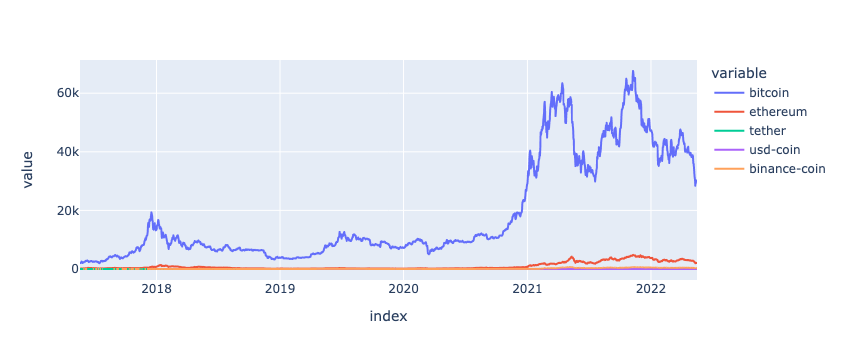

In [94]:
fig = px.line(melt_df, x=melt_df.index, y='value', color='variable')
fig.show()

In [123]:
returns_df = histories_df.pct_change(1)

In [96]:
(1 + returns_df).cumprod()

,bitcoin,ethereum,tether,usd-coin,binance-coin,xrp,binance-usd,cardano,solana,dogecoin,...,kava,kadena,lido-dao,holo,gatetoken,fei-protocol,kyber-network,qtum,bancor,1inch
2017-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-21,1.026185,1.067805,1.004166,NaN,1.000000,1.014179,NaN,NaN,NaN,1.492958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-22,1.072226,1.302580,1.004760,NaN,1.098008,0.912749,NaN,NaN,NaN,1.899119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-23,1.102083,1.306241,1.004962,NaN,1.098008,0.934600,NaN,NaN,NaN,2.119522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-24,1.185241,1.488939,1.010544,NaN,1.224289,0.937986,NaN,NaN,NaN,2.241264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.288510,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-13,15.160872,16.623147,1.010282,0.981754,34185.741652,1.289513,1.001233,24.091683,15.524261,57.259095,...,1.965853,4.326262,1.015775,3.077913,10.062238,0.996553,0.932868,0.656371,0.166489,0.144352
2022-05-14,14.778609,16.186053,1.010443,0.981965,32881.400058,1.252202,1.001094,22.707484,15.216707,55.966711,...,2.035888,4.714947,0.908086,2.951196,9.790962,0.988572,0.923299,0.642831,0.161428,0.149041
2022-05-15,15.137469,16.551304,1.010346,0.981425,34119.119177,1.269642,1.000704,23.832208,16.164686,56.481435,...,2.271492,6.203546,0.915617,2.981902,9.871251,0.989930,0.939198,0.665439,0.166412,0.150283
2022-05-16,15.076566,16.366510,1.011087,0.982063,34193.123896,1.262148,1.001340,24.661189,16.652086,55.933115,...,2.317466,5.913780,0.922578,2.929291,9.752441,0.982913,0.912789,0.663339,0.166096,0.149139


In [97]:
returns_df.index[0]

datetime.date(2017, 5, 20)

In [98]:
histories_df.index[0]

datetime.date(2017, 5, 20)

In [109]:
#start_date = date_conv("2020-08-22")
start_date = date.today() - timedelta(365)
end_date = date.today()

In [115]:
date.today() + timedelta(1)

datetime.date(2022, 5, 20)

In [121]:
rebased_df = (1 + returns_df[start_date:end_date]).cumprod()

In [122]:
rebased_df

,bitcoin,ethereum,tether,usd-coin,binance-coin,xrp,binance-usd,cardano,solana,dogecoin,...,kava,kadena,lido-dao,holo,gatetoken,fei-protocol,kyber-network,qtum,bancor,1inch
2021-05-18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-05-19,0.884820,0.824205,1.000344,1.001714,0.789828,0.839442,0.999916,0.817221,0.873883,0.805827,...,0.817679,NaN,NaN,0.791073,0.784263,0.987766,0.817818,0.783470,0.848854,0.808376
2021-05-20,0.901034,0.785915,1.000612,0.999406,0.717878,0.739656,0.999811,0.832182,0.805782,0.779162,...,0.760017,NaN,NaN,0.742670,0.768597,1.008721,0.760169,0.687406,0.787630,0.690640
2021-05-21,0.885123,0.766019,1.000714,1.000152,0.700415,0.694720,1.000049,0.804782,0.795526,0.774450,...,0.777062,NaN,NaN,0.732576,0.783653,1.002484,0.738114,0.681608,0.757616,0.663528
2021-05-22,0.848562,0.685858,1.000455,1.000321,0.603818,0.586702,1.000307,0.729324,0.682966,0.704567,...,0.680023,NaN,NaN,0.650140,0.637103,1.004619,0.651330,0.566850,0.665933,0.566806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-13,0.681549,0.604599,0.998198,0.999957,0.576863,0.276017,1.001566,0.269731,0.974123,0.185353,...,0.428042,4.326262,1.015775,0.247292,0.756632,1.030108,0.582691,0.223631,0.217846,0.177556
2022-05-14,0.664365,0.588701,0.998357,1.000172,0.554853,0.268031,1.001427,0.254233,0.954825,0.181170,...,0.443292,4.714947,0.908086,0.237111,0.736233,1.021858,0.576714,0.219018,0.211223,0.183323
2022-05-15,0.680497,0.601986,0.998261,0.999622,0.575739,0.271764,1.001037,0.266826,1.014309,0.182836,...,0.494592,6.203546,0.915617,0.239578,0.742271,1.023261,0.586645,0.226720,0.217745,0.184851
2022-05-16,0.677759,0.595265,0.998993,1.000272,0.576988,0.270160,1.001673,0.276107,1.044893,0.181061,...,0.504602,5.913780,0.922578,0.235351,0.733337,1.016008,0.570150,0.226005,0.217332,0.183444


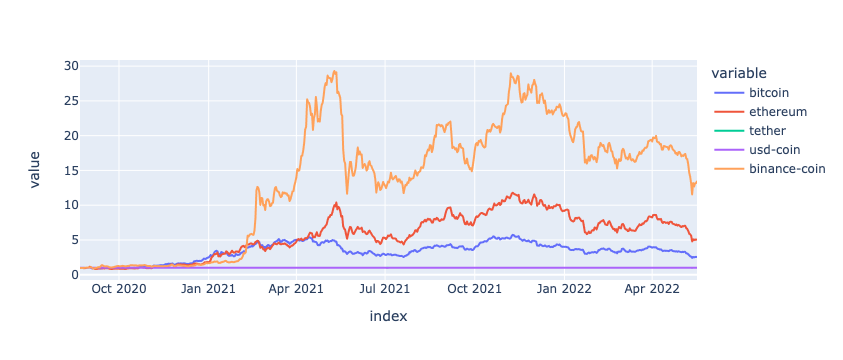

In [107]:
melt_df = pd.melt(rebased_df.iloc[:,:5], ignore_index=False)
fig = px.line(melt_df, x=melt_df.index, y='value', color='variable')
fig.show()

In [111]:
%%time
[date.today() - timedelta(x) for x in range(365 * 5)][::-1]

CPU times: user 4.64 ms, sys: 12 µs, total: 4.65 ms
Wall time: 4.69 ms


[datetime.date(2017, 5, 20),
 datetime.date(2017, 5, 21),
 datetime.date(2017, 5, 22),
 datetime.date(2017, 5, 23),
 datetime.date(2017, 5, 24),
 datetime.date(2017, 5, 25),
 datetime.date(2017, 5, 26),
 datetime.date(2017, 5, 27),
 datetime.date(2017, 5, 28),
 datetime.date(2017, 5, 29),
 datetime.date(2017, 5, 30),
 datetime.date(2017, 5, 31),
 datetime.date(2017, 6, 1),
 datetime.date(2017, 6, 2),
 datetime.date(2017, 6, 3),
 datetime.date(2017, 6, 4),
 datetime.date(2017, 6, 5),
 datetime.date(2017, 6, 6),
 datetime.date(2017, 6, 7),
 datetime.date(2017, 6, 8),
 datetime.date(2017, 6, 9),
 datetime.date(2017, 6, 10),
 datetime.date(2017, 6, 11),
 datetime.date(2017, 6, 12),
 datetime.date(2017, 6, 13),
 datetime.date(2017, 6, 14),
 datetime.date(2017, 6, 15),
 datetime.date(2017, 6, 16),
 datetime.date(2017, 6, 17),
 datetime.date(2017, 6, 18),
 datetime.date(2017, 6, 19),
 datetime.date(2017, 6, 20),
 datetime.date(2017, 6, 21),
 datetime.date(2017, 6, 22),
 datetime.date(2017, 6,

In [112]:
lookback_years = 5
end_date = date.today()

In [113]:
[end_date - timedelta(x) for x in range(365 * lookback_years)][::-1]

[datetime.date(2017, 5, 21),
 datetime.date(2017, 5, 22),
 datetime.date(2017, 5, 23),
 datetime.date(2017, 5, 24),
 datetime.date(2017, 5, 25),
 datetime.date(2017, 5, 26),
 datetime.date(2017, 5, 27),
 datetime.date(2017, 5, 28),
 datetime.date(2017, 5, 29),
 datetime.date(2017, 5, 30),
 datetime.date(2017, 5, 31),
 datetime.date(2017, 6, 1),
 datetime.date(2017, 6, 2),
 datetime.date(2017, 6, 3),
 datetime.date(2017, 6, 4),
 datetime.date(2017, 6, 5),
 datetime.date(2017, 6, 6),
 datetime.date(2017, 6, 7),
 datetime.date(2017, 6, 8),
 datetime.date(2017, 6, 9),
 datetime.date(2017, 6, 10),
 datetime.date(2017, 6, 11),
 datetime.date(2017, 6, 12),
 datetime.date(2017, 6, 13),
 datetime.date(2017, 6, 14),
 datetime.date(2017, 6, 15),
 datetime.date(2017, 6, 16),
 datetime.date(2017, 6, 17),
 datetime.date(2017, 6, 18),
 datetime.date(2017, 6, 19),
 datetime.date(2017, 6, 20),
 datetime.date(2017, 6, 21),
 datetime.date(2017, 6, 22),
 datetime.date(2017, 6, 23),
 datetime.date(2017, 6,

In [124]:
returns_df.shape

(1823, 100)

In [125]:
returns_df.head()

,bitcoin,ethereum,tether,usd-coin,binance-coin,xrp,binance-usd,cardano,solana,dogecoin,...,kava,kadena,lido-dao,holo,gatetoken,fei-protocol,kyber-network,qtum,bancor,1inch
2017-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-21,0.026185,0.067805,0.004166,NaN,0.000000,0.014179,NaN,NaN,NaN,0.492958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-22,0.044866,0.219867,0.000592,NaN,0.098008,-0.100012,NaN,NaN,NaN,0.272052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-23,0.027846,0.002811,0.000201,NaN,0.000000,0.023940,NaN,NaN,NaN,0.116055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-24,0.075455,0.139865,0.005555,NaN,0.115009,0.003623,NaN,NaN,NaN,0.057439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28851,NaN,NaN


In [126]:
start_date = date.today() - timedelta(365)
end_date = date.today()
investment_df = returns_df[start_date:end_date]

In [127]:
investment_df.head()

,bitcoin,ethereum,tether,usd-coin,binance-coin,xrp,binance-usd,cardano,solana,dogecoin,...,kava,kadena,lido-dao,holo,gatetoken,fei-protocol,kyber-network,qtum,bancor,1inch
2021-05-19,-0.115180,-0.175795,0.000344,0.001714,-0.210172,-0.160558,-0.000084,-0.182779,-0.126117,-0.194173,...,-0.182321,NaN,NaN,-0.208927,-0.215737,-0.012234,-0.182182,-0.216530,-0.151146,-0.191624
2021-05-20,0.018324,-0.046458,0.000268,-0.002304,-0.091096,-0.118872,-0.000105,0.018307,-0.077929,-0.033091,...,-0.070520,NaN,NaN,-0.061187,-0.019975,0.021214,-0.070491,-0.122613,-0.072125,-0.145646
2021-05-21,-0.017658,-0.025315,0.000102,0.000747,-0.024327,-0.060753,0.000238,-0.032925,-0.012728,-0.006047,...,0.022428,NaN,NaN,-0.013591,0.019588,-0.006183,-0.029013,-0.008434,-0.038107,-0.039256
2021-05-22,-0.041307,-0.104646,-0.000258,0.000169,-0.137914,-0.155483,0.000257,-0.093762,-0.141491,-0.090236,...,-0.124879,NaN,NaN,-0.112529,-0.187009,0.002130,-0.117576,-0.168363,-0.121015,-0.145770
2021-05-23,-0.065218,-0.104612,0.000092,0.000878,-0.155485,-0.123637,0.000165,-0.124935,-0.279095,-0.080092,...,-0.108002,NaN,NaN,-0.130236,-0.141261,-0.000125,-0.156447,-0.152963,-0.140479,-0.167531


In [128]:
investment_df.shape

(364, 100)

In [129]:
#drop NA cols
investment_df.dropna(axis=1, inplace=True)

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_23487/1846595957.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [130]:
investment_df.shape

(364, 87)

In [132]:
investment_cols = investment_df.columns[0:5]

In [142]:
num_coins = 5
col_indicator = [1 if x in investment_cols else 0 for x in returns_df.columns]
weights = [1/num_coins for _ in range(num_coins)]

In [148]:
investment_cols

Index(['bitcoin', 'ethereum', 'tether', 'usd-coin', 'binance-coin'], dtype='object')

In [153]:
[start_date,start_date]

[datetime.date(2021, 5, 19), datetime.date(2021, 5, 19)]

In [139]:
rebased_df.dot(weights)

2021-05-18    1.000000
2021-05-19         NaN
2021-05-20         NaN
2021-05-21         NaN
2021-05-22         NaN
                ...   
2022-05-13    0.772233
2022-05-14    0.761289
2022-05-15    0.771221
2022-05-16    0.769855
2022-05-17    0.774480
Length: 365, dtype: float64

In [154]:
investment_df = returns_df[investment_cols]
investment_df[start_date:start_date]=0

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_23487/181279341.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_23487/181279341.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [156]:
rebased_df = (1 + investment_df[start_date:end_date]).cumprod()

In [157]:
rebased_df.head()

,bitcoin,ethereum,tether,usd-coin,binance-coin
2021-05-19,1.000000,1.000000,1.000000,1.000000,1.000000
2021-05-20,1.018324,0.953542,1.000268,0.997696,0.908904
2021-05-21,1.000343,0.929403,1.000370,0.998441,0.886794
2021-05-22,0.959023,0.832145,1.000112,0.998610,0.764492
2021-05-23,0.896477,0.745093,1.000204,0.999487,0.645625


In [158]:
weights

[0.2, 0.2, 0.2, 0.2, 0.2]

In [160]:
port_returns = rebased_df.dot(weights)

In [162]:
port_returns.index.name = 'date'

In [165]:
port_returns.name = 'price (USD)'

In [166]:
port_returns

date
2021-05-19    1.000000
2021-05-20    0.975747
2021-05-21    0.963070
2021-05-22    0.910876
2021-05-23    0.857377
                ...   
2022-05-13    0.846058
2022-05-14    0.832817
2022-05-15    0.844847
2022-05-16    0.843189
2022-05-17    0.848875
Name: price (USD), Length: 364, dtype: float64